In [1]:
import numpy as np
import pickle
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
METHOD = 'cnn_self-training-add-part'

LABELLED_DATA_FILE = 'data/all_label.p'
UNLABELED_DATA_FILE = 'data/all_unlabel.p'
TEST_DATA_FILE = 'data/test.p'

OUTPUT_FOLDER = 'output/'
MODEL_FOLDER = 'model/' + METHOD + '/'

In [3]:
import os
if not os.path.exists(MODEL_FOLDER):
    os.makedirs(MODEL_FOLDER)
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

# Train

### Loading Training Data

In [4]:
labelled_data = np.array(pickle.load(open(LABELLED_DATA_FILE, 'rb')))
unlabeled_data = np.array(pickle.load(open(UNLABELED_DATA_FILE, 'rb')))

In [5]:
nb_classes = 10
img_rows, img_cols, img_channels = 32, 32, 3

In [6]:
# generate x, y from data

# reshape labelled data to (5000, 3, 32, 32)
X_train_label = labelled_data.reshape((5000, img_channels, img_rows, img_cols)).astype('float32') / 255

# reshape unlabeled data to (45000, 3, 32, 32)
nb_unlabeled_data = unlabeled_data.shape[0]
X_train_unlabel = unlabeled_data.reshape((nb_unlabeled_data, img_channels, img_rows, img_cols)).astype('float32') / 255

y_train_label_class = np.array([classIdx for classIdx in range(len(labelled_data)) for i in range(len(labelled_data[classIdx]))])
Y_train_label = np_utils.to_categorical(y_train_label_class, nb_classes)

In [7]:
# TODO: remove

from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train_reshaped = np.array([[img[:, :, 0], img[:, :, 1], img[:, :, 2]] for img in X_train]) / 255.0
X_test_reshaped = np.array([[img[:, :, 0], img[:, :, 1], img[:, :, 2]] for img in X_test]) / 255.0
Y_test_categ = np_utils.to_categorical(y_test.flatten(), 10)

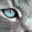

In [8]:
# visualize
from scipy.misc import toimage
toimage(X_train_unlabel[5])

### Training

In [9]:
from scipy.stats import entropy

def certainty(prob_arr):  # higher is more certain
    return -entropy(prob_arr)

def uncertainty(prob_arr):  # lower is better. for descending-ordered sorting
    return entropy(prob_arr)

#     sorted_arr = np.sort(prob_arr)
#     return sorted_arr[-1] / sorted_arr[-2]

In [10]:
batch_size = 64
nb_epoch = 100

In [11]:
# set model

def reset_model():

    model = Sequential()

    model.add(Convolution2D(64, 3, 3, border_mode='same', dim_ordering="th", input_shape=X_train_label.shape[1:]))
    model.add(Activation('relu'))
#     model.add(Convolution2D(32, 3, 3))
#     model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same', dim_ordering="th"))
    model.add(Dropout(0.5))

    model.add(Convolution2D(64, 3, 3, border_mode='same', dim_ordering="th"))
    model.add(Activation('relu'))
#     model.add(Convolution2D(64, 3, 3))
#     model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same', dim_ordering="th"))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [12]:
# avoid change to the original labelled data
X_train_ori_label = np.copy(X_train_label)
Y_train_ori_label = np.copy(Y_train_label)
X_train_ori_unlabel = np.copy(X_train_unlabel)

In [13]:
extract_ratio = 0.25
nb_extract_rounds = 3

In [16]:
# extract high-certainty labelled-unlabeled data and add to labelled dataset

# TODO: remove (X_test_reshaped, Y_test_categ),

for extract_round in range(nb_extract_rounds):
    nb_epoch = int(500000 / X_train_label.shape[0])
    
    print('extract_round:', extract_round+1)
    # reset model
    model = reset_model()
    
    # train model
    model.fit(X_train_label, Y_train_label,
        batch_size=batch_size,
        nb_epoch=nb_epoch,  # nb_epoch,
        validation_data=(X_test_reshaped, Y_test_categ),
        shuffle=True)
    
    # save model

    # use the model to label unlabeled data
    Y_train_unlabel_proba = model.predict_proba(X_train_unlabel, batch_size=10000)  # same as model.predict
    Y_train_unlabel_uncertainty = np.apply_along_axis(uncertainty, 1, Y_train_unlabel_proba)
    
    Y_train_unlabel_class = model.predict_classes(X_train_unlabel, batch_size=10000)
    Y_train_unlabel = np_utils.to_categorical(Y_train_unlabel_class, nb_classes)

    # sort unlabeled data by uncertainty
    sorted_idxs = Y_train_unlabel_uncertainty.argsort()
    X_train_unlabel = X_train_unlabel[sorted_idxs]
    Y_train_unlabel = Y_train_unlabel[sorted_idxs]
    
    # extract high-certainty unlabeled data
    nb_extract = int(X_train_unlabel.shape[0] * extract_ratio)
    X_train_unlabel_certain, X_train_unlabel_uncertain = X_train_unlabel[:nb_extract], X_train_unlabel[nb_extract:]
    Y_train_unlabel_certain, Y_train_unlabel_uncertain = Y_train_unlabel[:nb_extract], Y_train_unlabel[nb_extract:]

    # update labelled dataset and unlabeled dataset
    X_train_label = np.concatenate((X_train_label, X_train_unlabel_certain))
    Y_train_label = np.concatenate((Y_train_label, Y_train_unlabel_certain))
    X_train_unlabel = X_train_unlabel_uncertain
    Y_train_unlabel = Y_train_unlabel_uncertain

extract_round: 1
Train on 5000 samples, validate on 10000 samples
Epoch 1/100
5000/5000 [==============================] - 2s - loss: 2.1764 - acc: 0.1888 - val_loss: 2.4777 - val_acc: 0.1205
Epoch 2/100
5000/5000 [==============================] - 2s - loss: 1.8691 - acc: 0.3232 - val_loss: 2.4799 - val_acc: 0.1592
Epoch 3/100
5000/5000 [==============================] - 2s - loss: 1.7166 - acc: 0.3736 - val_loss: 2.3842 - val_acc: 0.1865
Epoch 4/100
5000/5000 [==============================] - 2s - loss: 1.6226 - acc: 0.4118 - val_loss: 2.1325 - val_acc: 0.2428
Epoch 5/100
5000/5000 [==============================] - 2s - loss: 1.5579 - acc: 0.4318 - val_loss: 2.3116 - val_acc: 0.2242
Epoch 6/100
5000/5000 [==============================] - 2s - loss: 1.4582 - acc: 0.4786 - val_loss: 2.2056 - val_acc: 0.2430
Epoch 7/100
5000/5000 [==============================] - 2s - loss: 1.3769 - acc: 0.5058 - val_loss: 2.1883 - val_acc: 0.2676
Epoch 8/100
5000/5000 [=============================

In [16]:
# set model

def reset_model_2():

    model = Sequential()

    model.add(Convolution2D(64, 3, 3, border_mode='same', dim_ordering="th", input_shape=X_train_label.shape[1:]))
    model.add(Activation('relu'))
#     model.add(Convolution2D(64, 3, 3))
#     model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same', dim_ordering="th"))
    model.add(Dropout(0.5))

    model.add(Convolution2D(64, 3, 3, border_mode='same', dim_ordering="th"))
    model.add(Activation('relu'))
#     model.add(Convolution2D(64, 3, 3))
#     model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same', dim_ordering="th"))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [17]:
model_bak = model

model = reset_model_2()

# TODO: remove (X_test_reshaped, Y_test_categ),

model.fit(X_train_label, Y_train_label,
    batch_size=batch_size,
    nb_epoch=100,  # nb_epoch,
    validation_data=(X_test_reshaped, Y_test_categ),
    shuffle=True)

Train on 16250 samples, validate on 10000 samples
Epoch 1/100
16250/16250 [==============================] - 5s - loss: 1.4473 - acc: 0.5078 - val_loss: 2.5511 - val_acc: 0.1915
Epoch 2/100
16250/16250 [==============================] - 5s - loss: 0.9391 - acc: 0.6902 - val_loss: 2.2550 - val_acc: 0.2689
Epoch 3/100
16250/16250 [==============================] - 5s - loss: 0.7727 - acc: 0.7449 - val_loss: 2.1235 - val_acc: 0.3000
Epoch 4/100
16250/16250 [==============================] - 4s - loss: 0.6811 - acc: 0.7770 - val_loss: 2.3524 - val_acc: 0.2834
Epoch 5/100
16250/16250 [==============================] - 5s - loss: 0.6295 - acc: 0.7956 - val_loss: 2.0804 - val_acc: 0.3232
Epoch 6/100
16250/16250 [==============================] - 5s - loss: 0.5739 - acc: 0.8124 - val_loss: 2.0535 - val_acc: 0.3360
Epoch 7/100
16250/16250 [==============================] - 5s - loss: 0.5570 - acc: 0.8224 - val_loss: 1.9920 - val_acc: 0.3517
Epoch 8/100
16250/16250 [=============================

KeyboardInterrupt: 

In [ ]:
Y_train_label_class_predict = model.predict_classes(X_train_ori_label, batch_size=5000)
val_acc = np.sum(Y_train_label_class_predict == y_train_label_class) / float(len(y_train_label_class))
val_acc

In [19]:
model_name = (METHOD
    + '_filters-64w3-64w3-512'
    + '_add-0.25'
    + '_epo-100x3' # + str(nb_epoch)
    + '_0.4192' # + str(val_acc)[:6]
)
model.save(MODEL_FOLDER + model_name)

# Test

### Loading test data 

In [21]:
test_data = pickle.load(open(TEST_DATA_FILE, 'rb'))  # dict
X_test = np.array(test_data['data']).reshape((10000, 3, 32, 32)).astype('float32')
X_test /= 255

### Predict

In [22]:
result = model.predict_classes(X_test, batch_size=10000)
csv_content = list(zip(test_data['ID'], result.tolist()))
np.savetxt(OUTPUT_FOLDER + model_name + ".csv", csv_content, fmt="%i", header="ID,class", comments="", delimiter=",")

10000/10000 [==============================] - 1s


In [27]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [28]:
X_train_reshaped = np.array([[img[:, :, 0], img[:, :, 1], img[:, :, 2]] for img in X_train])
X_test_reshaped = np.array([[img[:, :, 0], img[:, :, 1], img[:, :, 2]] for img in X_test])

In [18]:
Y_test_class_predict = model.predict_classes(X_test_reshaped, batch_size=10000)
np.sum(Y_test_class_predict == y_test.flatten()) / len(y_test)

10000/10000 [==============================] - 1s


0.41920000000000002

In [30]:
Y_train_class_predict = model.predict_classes(X_train_reshaped, batch_size=10000)
np.sum(Y_train_class_predict == y_train.flatten()) / len(y_train)

50000/50000 [==============================] - 1s     


0.24102000000000001

In [ ]:
toimage(X_train_reshaped[2])

In [ ]:
Y_train_class_predict[:10]

In [ ]:
y_train[:10]

In [ ]:
toimage(X_train_reshaped[1])